In [1]:
# Project Hyperion: Hardware Exploration
# This notebook explores the AMD MI250X GPU capabilities and verifies our PyTorch setup

# Cell 1: Import necessary libraries
import torch
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import time
import pandas as pd
from tabulate import tabulate
%matplotlib inline

print(f"PyTorch version: {torch.__version__}")
print(f"Python version: {sys.version}")

PyTorch version: 2.3.0a0+git96dd291
Python version: 3.10.14 (main, May  6 2024, 19:42:50) [GCC 11.2.0]


PyTorch version: 2.3.0a0+git96dd291
Python version: 3.10.14 (main, May  6 2024, 19:42:50) [GCC 11.2.0]
ROCm available: True
GPU available: True
Number of GPUs: 1
GPU 0: AMD Instinct MI250X/MI250
Allocated GPU memory: 0.00 MB
Reserved GPU memory: 13880.00 MB
Tensor creation time: 0.0008 seconds
Matrix multiplication time: 0.0074 seconds
Element-wise operation time: 0.0006 seconds
+----+-----------+-------------+-------------+----------+
|    | Size      | Precision   |    Time (s) |   TFLOPS |
+====+===========+=============+=============+==========+
|  0 | 1024x1024 | FP32        | 0.000172377 |  12.4581 |
+----+-----------+-------------+-------------+----------+
|  1 | 1024x1024 | FP16        | 0.000139475 |  15.3969 |
+----+-----------+-------------+-------------+----------+
|  2 | 1024x1024 | BF16        | 0.000126839 |  16.9308 |
+----+-----------+-------------+-------------+----------+
|  3 | 2048x2048 | FP32        | 0.000577688 |  29.739  |
+----+-----------+-------------+------

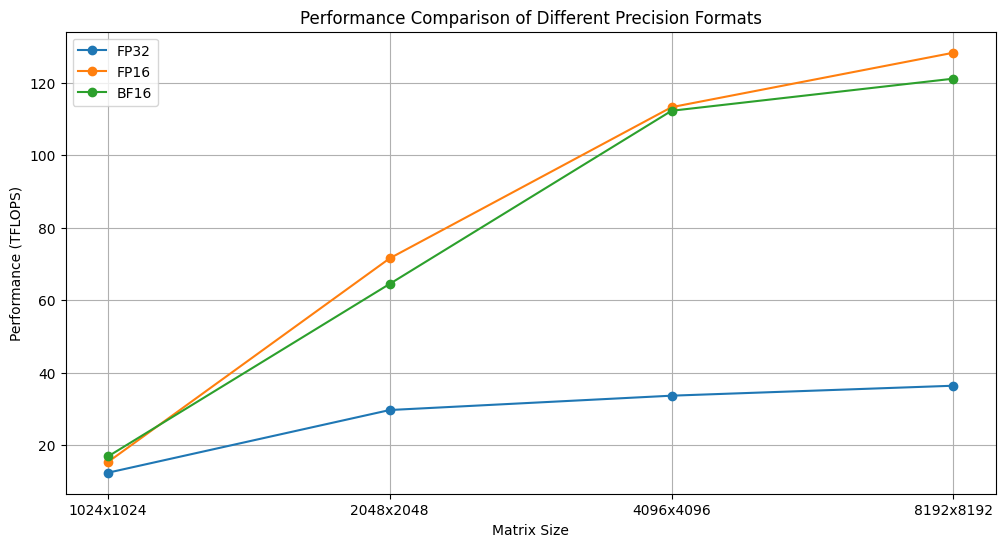

+----+---------------------+--------------------+
|    |   Size (M elements) |   Bandwidth (GB/s) |
+====+=====================+====================+
|  0 |                  10 |            796.387 |
+----+---------------------+--------------------+
|  1 |                  20 |            991.757 |
+----+---------------------+--------------------+
|  2 |                  50 |           1248.92  |
+----+---------------------+--------------------+
|  3 |                 100 |           1266.2   |
+----+---------------------+--------------------+
|  4 |                 200 |           1261.13  |
+----+---------------------+--------------------+
|  5 |                 500 |           1268.89  |
+----+---------------------+--------------------+


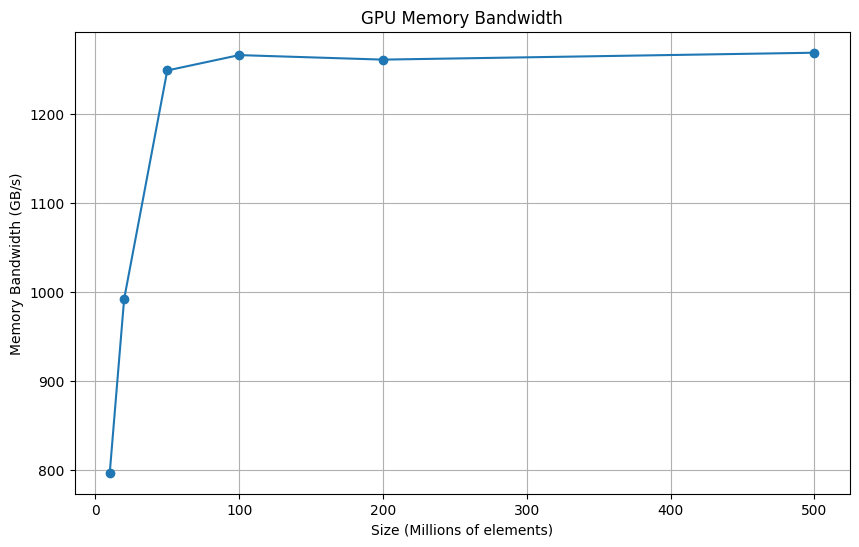

Hardware exploration completed and results saved.


In [6]:
# Project Hyperion: Hardware Exploration
# This notebook explores the AMD MI250X GPU capabilities and verifies our PyTorch setup

# Cell 1: Import necessary libraries
import torch
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import time
from tabulate import tabulate
import pandas as pd
%matplotlib inline

# Cell 2: Check PyTorch and ROCm versions
print(f"PyTorch version: {torch.__version__}")
print(f"Python version: {sys.version}")
print(f"ROCm available: {torch.backends.cudnn.is_available()}")
print(f"GPU available: {torch.cuda.is_available()}")
print(f"Number of GPUs: {torch.cuda.device_count()}")
for i in range(torch.cuda.device_count()):
    print(f"GPU {i}: {torch.cuda.get_device_name(i)}")

# Cell 3: Check GPU memory
def get_gpu_memory():
    """Get the current GPU memory usage."""
    torch.cuda.synchronize()
    return torch.cuda.memory_allocated() / 1024**2, torch.cuda.memory_reserved() / 1024**2

allocated, reserved = get_gpu_memory()
print(f"Allocated GPU memory: {allocated:.2f} MB")
print(f"Reserved GPU memory: {reserved:.2f} MB")

# Cell 4: Test basic GPU operations
def test_gpu_operations():
    """Test basic GPU operations and measure performance."""
    # Create tensors on GPU
    torch.cuda.synchronize()
    start_time = time.time()
    
    # Test tensor creation
    x = torch.rand(5000, 5000, device='cuda')
    y = torch.rand(5000, 5000, device='cuda')
    
    torch.cuda.synchronize()
    tensor_time = time.time() - start_time
    print(f"Tensor creation time: {tensor_time:.4f} seconds")
    
    # Test matrix multiplication
    start_time = time.time()
    z = torch.matmul(x, y)
    torch.cuda.synchronize()
    matmul_time = time.time() - start_time
    print(f"Matrix multiplication time: {matmul_time:.4f} seconds")
    
    # Test element-wise operations
    start_time = time.time()
    w = torch.sin(x) + torch.cos(y)
    torch.cuda.synchronize()
    element_time = time.time() - start_time
    print(f"Element-wise operation time: {element_time:.4f} seconds")
    
    return {
        "tensor_creation": tensor_time,
        "matrix_multiplication": matmul_time,
        "element_wise_operations": element_time
    }

results = test_gpu_operations()

# Cell 5: Test different precision formats
def test_precision_formats():
    """Test performance with different precision formats."""
    sizes = [1024, 2048, 4096, 8192]
    dtypes = [torch.float32, torch.float16, torch.bfloat16]
    dtype_names = ["FP32", "FP16", "BF16"]
    
    results = []
    
    for size in sizes:
        for i, dtype in enumerate(dtypes):
            try:
                # Skip if not supported
                if not torch.cuda.is_available() or not hasattr(torch, dtype.__str__().split('.')[-1]):
                    continue
                
                torch.cuda.synchronize()
                start_time = time.time()
                
                x = torch.rand(size, size, dtype=dtype, device='cuda')
                y = torch.rand(size, size, dtype=dtype, device='cuda')
                z = torch.matmul(x, y)
                
                torch.cuda.synchronize()
                end_time = time.time()
                
                results.append({
                    "Size": f"{size}x{size}",
                    "Precision": dtype_names[i],
                    "Time (s)": end_time - start_time,
                    "TFLOPS": (2 * size**3) / (end_time - start_time) / 1e12
                })
            except Exception as e:
                print(f"Error with {dtype_names[i]} at size {size}: {e}")
    
    return pd.DataFrame(results)

precision_results = test_precision_formats()
print(tabulate(precision_results, headers="keys", tablefmt="grid"))

# Cell 6: Visualize precision performance
plt.figure(figsize=(12, 6))
for precision in ["FP32", "FP16", "BF16"]:
    if precision in precision_results["Precision"].values:
        data = precision_results[precision_results["Precision"] == precision]
        plt.plot(data["Size"], data["TFLOPS"], marker='o', label=precision)

plt.xlabel("Matrix Size")
plt.ylabel("Performance (TFLOPS)")
plt.title("Performance Comparison of Different Precision Formats")
plt.legend()
plt.grid(True)
plt.savefig("precision_performance.png")
plt.show()

# Cell 7: Test memory bandwidth
def test_memory_bandwidth():
    """Measure memory bandwidth of the GPU."""
    sizes = [10, 20, 50, 100, 200, 500]  # Millions of elements
    bandwidths = []
    
    for size in sizes:
        # Convert to actual size
        n = size * 1000000
        
        # Allocate tensors
        torch.cuda.synchronize()
        start_time = time.time()
        
        x = torch.rand(n, device='cuda')
        y = torch.rand(n, device='cuda')
        z = torch.empty(n, device='cuda')
        
        # Memory copy operation (z = x + y)
        torch.cuda.synchronize()
        copy_start = time.time()
        
        z = x + y
        
        torch.cuda.synchronize()
        copy_end = time.time()
        
        # Calculate bandwidth (bytes per second)
        # Each operation reads 2 floats (x and y) and writes 1 float (z)
        # Each float is 4 bytes
        bytes_transferred = n * 4 * 3
        time_taken = copy_end - copy_start
        bandwidth = bytes_transferred / time_taken / 1e9  # Convert to GB/s
        
        bandwidths.append({
            "Size (M elements)": size,
            "Bandwidth (GB/s)": bandwidth
        })
    
    return pd.DataFrame(bandwidths)

bandwidth_results = test_memory_bandwidth()
print(tabulate(bandwidth_results, headers="keys", tablefmt="grid"))

plt.figure(figsize=(10, 6))
plt.plot(bandwidth_results["Size (M elements)"], bandwidth_results["Bandwidth (GB/s)"], marker='o')
plt.xlabel("Size (Millions of elements)")
plt.ylabel("Memory Bandwidth (GB/s)")
plt.title("GPU Memory Bandwidth")
plt.grid(True)
plt.savefig("memory_bandwidth.png")
plt.show()

# Cell 8: Save results
os.makedirs("/home/aac/results/benchmarks/hardware", exist_ok=True)
precision_results.to_csv("/home/aac/results/benchmarks/hardware/precision_results.csv", index=False)
bandwidth_results.to_csv("/home/aac/results/benchmarks/hardware/bandwidth_results.csv", index=False)

print("Hardware exploration completed and results saved.")
